In [1]:
import pandas as pd
import numpy as np
import config
import datetime
from sqlalchemy import text
import plotly
import plotly.express as px
import ipywidgets
from urllib.request import urlopen
import json
import plotly.graph_objects as go
import geopandas as gpd
import warnings
import pyproj
import plotly.io as pio
print(config.version)
print(config.connection_string)
print(plotly.__version__, ipywidgets.__version__, pd.__version__, np.__version__)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', category=UserWarning) 

3.2.0.Dev
postgresql://postgres:sa@localhost/icip
6.3.1 8.1.7 2.0.0 1.26.4


In [2]:
# Charger et filtrer les données
gdf = gpd.read_file("contours-iris.gpkg")
gdf = gdf[gdf["nom_commune"] == "Nice"].to_crs(epsg=4326)
gdf_l93 = gdf.to_crs(2154)
pts_l93 = gdf_l93.geometry.representative_point()
pts = pts_l93.to_crs(4326)
gdf["fid"] = gdf.index
gdf["lon"] = gdf.geometry.centroid.x
gdf["lat"] = gdf.geometry.centroid.y
gdf=gdf.sort_values(by="code_iris")
geojson=gdf.__geo_interface__
gdf

,cleabs,code_insee,nom_commune,iris,code_iris,nom_iris,type_iris,geometry,fid,lon,lat
2597,IRIS____0000000060880101,06088,Nice,0101,060880101,Saleya-Château,H,"MULTIPOLYGON (((7.28193 43.69312, 7.28159 43.6...",2597,7.277064,43.695476
4458,IRIS____0000000060880102,06088,Nice,0102,060880102,Vieux Nice-Sainte-Réparate,H,"MULTIPOLYGON (((7.27454 43.69773, 7.27598 43.6...",4458,7.275641,43.697293
5715,IRIS____0000000060880103,06088,Nice,0103,060880103,Vieux Nice-Visitation,H,"MULTIPOLYGON (((7.27842 43.70006, 7.27884 43.7...",5715,7.279384,43.698417
9348,IRIS____0000000060880201,06088,Nice,0201,060880201,Garibaldi,H,"MULTIPOLYGON (((7.27904 43.70126, 7.28007 43.7...",9348,7.281249,43.702325
9785,IRIS____0000000060880202,06088,Nice,0202,060880202,Port,H,"MULTIPOLYGON (((7.29038 43.69227, 7.29029 43.6...",9785,7.285948,43.695477
...,...,...,...,...,...,...,...,...,...,...,...
14763,IRIS____0000000060883501,06088,Nice,3501,060883501,Crémat-Bellet,H,"MULTIPOLYGON (((7.20972 43.75747, 7.21002 43.7...",14763,7.210291,43.733731
14773,IRIS____0000000060883601,06088,Nice,3601,060883601,Saint-Pierre de Féric,H,"MULTIPOLYGON (((7.22218 43.72576, 7.22231 43.7...",14773,7.232767,43.720739
14774,IRIS____0000000060883602,06088,Nice,3602,060883602,Costière,H,"MULTIPOLYGON (((7.22543 43.71696, 7.22593 43.7...",14774,7.235730,43.709542
14786,IRIS____0000000060883701,06088,Nice,3701,060883701,Saint-Pancrace-Pessicart,H,"MULTIPOLYGON (((7.222 43.74145, 7.22215 43.741...",14786,7.237896,43.735819


In [11]:
sql = """
    select e.nofinesset, e.rs, an.id an_id, an.score, an.lon, an.lat, an.iris, i.id, c.code code_commune, c.nom from etablissement e
join etablissement_date_source eds on eds.etablissement_id=e.id
join adresse_raw ar on ar.id=e.adresse_raw_id
join adresse_norm an on an.id=ar.adresse_norm_id
join iris.iris i on i.code=an.iris
join iris.commune c on c.id=i.commune_id
where categretab>4400 and categretab<4405
and date_source_id=2312
and c.code='06088'
"""
etab=pd.read_sql(sql, config.connection_string)
etab["pos"]=etab["an_id"].astype(str)+"_"+etab["rs"]+"_"+etab["score"].astype(str)+"_"+etab["lon"].astype(str)+"_"+etab["lat"].astype(str)
etab

,nofinesset,rs,an_id,score,lon,lat,iris,id,code_commune,nom,pos
0,060013059,EHPAD LE CLOS DE CIMIEZ,1505,1.000000,7.280142,43.723042,060881001,60881001,06088,Nice,1505_EHPAD LE CLOS DE CIMIEZ_1.0_7.28014202450...
1,060022902,EHPAD DE NICE,105583,1.000000,7.273405,43.720996,060881004,60881004,06088,Nice,105583_EHPAD DE NICE_1.0_7.273405_43.720996
2,060003316,EHPAD RESIDENCE ANCILLA,104855,1.000000,7.261982,43.706914,060881803,60881803,06088,Nice,104855_EHPAD RESIDENCE ANCILLA_1.0_7.261982_43...
3,060012069,EHPAD LA CORNICHE FLEURIE,105118,0.934300,7.205966,43.689311,060883101,60883101,06088,Nice,105118_EHPAD LA CORNICHE FLEURIE_0.93430049906...
4,060012879,KORIAN SORGENTINO,105151,0.849500,7.286194,43.704588,060880303,60880303,06088,Nice,105151_KORIAN SORGENTINO_0.8495000000000001_7....
5,060013299,EHPAD LA PALMERAIE,105166,1.000000,7.244136,43.714039,060883701,60883701,06088,Nice,105166_EHPAD LA PALMERAIE_1.0_7.244136_43.714039
6,060013588,KORIAN CHATEAU DES OLLIERES,105179,1.000000,7.248274,43.695203,060882603,60882603,06088,Nice,105179_KORIAN CHATEAU DES OLLIERES_1.0_7.24827...
7,060024049,RESIDENCE AUTONOMIE ST JEAN D'ANGELY,105644,0.949500,7.290118,43.708903,060880502,60880502,06088,Nice,105644_RESIDENCE AUTONOMIE ST JEAN D'ANGELY_0....
8,060024262,EHPAD VILLA DE RIMIEZ,105656,1.000000,7.268087,43.744370,060883801,60883801,06088,Nice,105656_EHPAD VILLA DE RIMIEZ_1.0_7.268087_43.7...
9,060020138,EHPAD INSTITUT CLAUDE POMPIDOU,104932,1.000000,7.259798,43.713029,060881505,60881505,06088,Nice,104932_EHPAD INSTITUT CLAUDE POMPIDOU_1.0_7.25...


In [4]:
sql="""
with ir as (
	select i.code, count(e.id)
	from etablissement e
	join etablissement_date_source eds on eds.etablissement_id=e.id
	join adresse_raw ar on ar.id=e.adresse_raw_id
	join adresse_norm an on an.id=ar.adresse_norm_id
	join iris.iris i on i.code=an.iris
	join iris.commune c on c.id=i.commune_id
	where categretab>4400 and categretab<4405
	and eds.date_source_id=2312
	and c.code='06088'
	group by i.id
)
select i.code code_iris, coalesce(ir.count,0) nb, pi.pop80p from iris.iris i
join iris.commune c on c.id=i.commune_id
left outer join ir on ir.code=i.code
join iris.pop_iris pi on pi.iris_id=i.id and pi.year=21
where c.code='06088'

"""
pop=pd.read_sql(sql, config.connection_string)
pop

,code_iris,nb,pop80p
0,060880101,0,143.792641
1,060880102,0,61.509567
2,060880103,0,136.557391
3,060880201,0,215.180567
4,060880202,0,175.081808
...,...,...,...
141,060883501,0,151.798222
142,060883601,1,175.835066
143,060883602,0,80.290586
144,060883701,1,276.802997


In [5]:
gdf = gdf.merge(pop, on="code_iris", how="left", suffixes=('', '')).copy()
gdf

,cleabs,code_insee,nom_commune,iris,code_iris,nom_iris,type_iris,geometry,fid,lon,lat,nb,pop80p
0,IRIS____0000000060880101,06088,Nice,0101,060880101,Saleya-Château,H,"MULTIPOLYGON (((7.28193 43.69312, 7.28159 43.6...",2597,7.277064,43.695476,0,143.792641
1,IRIS____0000000060880102,06088,Nice,0102,060880102,Vieux Nice-Sainte-Réparate,H,"MULTIPOLYGON (((7.27454 43.69773, 7.27598 43.6...",4458,7.275641,43.697293,0,61.509567
2,IRIS____0000000060880103,06088,Nice,0103,060880103,Vieux Nice-Visitation,H,"MULTIPOLYGON (((7.27842 43.70006, 7.27884 43.7...",5715,7.279384,43.698417,0,136.557391
3,IRIS____0000000060880201,06088,Nice,0201,060880201,Garibaldi,H,"MULTIPOLYGON (((7.27904 43.70126, 7.28007 43.7...",9348,7.281249,43.702325,0,215.180567
4,IRIS____0000000060880202,06088,Nice,0202,060880202,Port,H,"MULTIPOLYGON (((7.29038 43.69227, 7.29029 43.6...",9785,7.285948,43.695477,0,175.081808
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,IRIS____0000000060883501,06088,Nice,3501,060883501,Crémat-Bellet,H,"MULTIPOLYGON (((7.20972 43.75747, 7.21002 43.7...",14763,7.210291,43.733731,0,151.798222
142,IRIS____0000000060883601,06088,Nice,3601,060883601,Saint-Pierre de Féric,H,"MULTIPOLYGON (((7.22218 43.72576, 7.22231 43.7...",14773,7.232767,43.720739,1,175.835066
143,IRIS____0000000060883602,06088,Nice,3602,060883602,Costière,H,"MULTIPOLYGON (((7.22543 43.71696, 7.22593 43.7...",14774,7.235730,43.709542,0,80.290586
144,IRIS____0000000060883701,06088,Nice,3701,060883701,Saint-Pancrace-Pessicart,H,"MULTIPOLYGON (((7.222 43.74145, 7.22215 43.741...",14786,7.237896,43.735819,1,276.802997


0.1413283687149809 0.11550385287036846 12.028724419995367 6.586716312850191


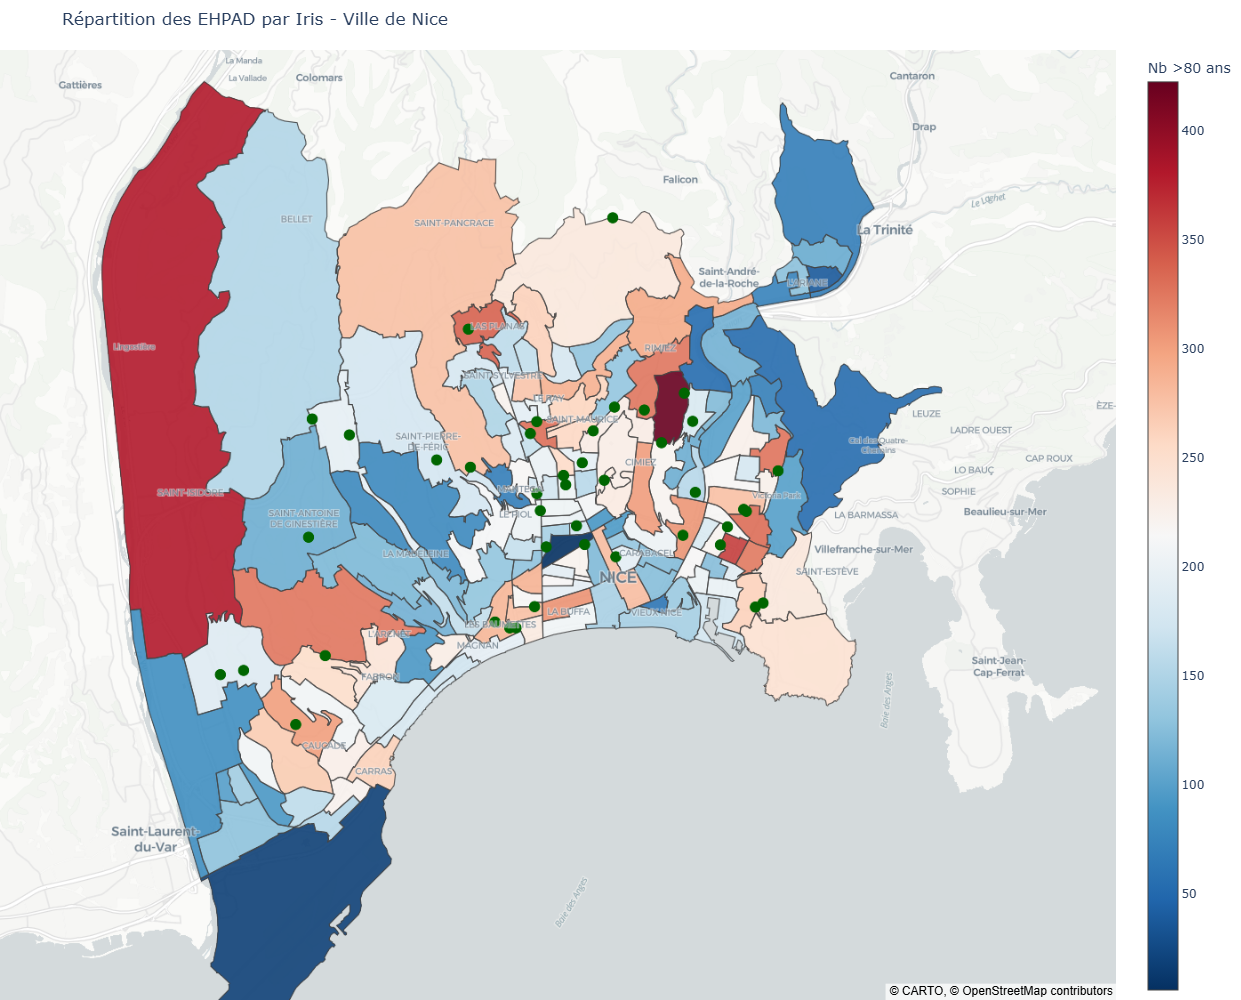

In [10]:
hover_enabled=True

fig = go.Figure()

z_values=gdf["pop80p"]

fig.add_trace(go.Choroplethmap(
    geojson=geojson,
    locations=gdf["fid"],
    z=z_values,
    zmin=z_values.min(),
    zmax=z_values.max(),
    text=gdf.apply(
        lambda row: f"Nom: {row['nom_iris']}<br>Nb: {row['nb']}<br>Population >80ans: {np.round(row['pop80p'],0):.0f}",
        axis=1
    ),
    hoverinfo="text",
    showscale=True,
    marker=dict(opacity=0.9),
    colorscale="RdBu_r",
    colorbar={"title": "Nb >80 ans"},
))

center_lat = gdf.geometry.centroid.y.mean()
center_lon = gdf.geometry.centroid.x.mean()

# Ajouter les étiquettes
gdf_l93 = gdf.to_crs(2154)
pts_l93 = gdf_l93.geometry.representative_point()
pts = pts_l93.to_crs(4326)

fig.add_trace(go.Scattermap(
    lon=etab["lon"],
    lat=etab["lat"],
    text=etab["pos"],
    hoverinfo="text" if hover_enabled else "skip",
    showlegend=False,
    mode="markers",
    marker=dict(
        color='#006600',
        size=12,
        # line=dict(color='#006600', width=2)
    )

))


bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
lon_range = bounds[2] - bounds[0]
lat_range = bounds[3] - bounds[1]

zoom = 1 / max(lon_range, lat_range) * 1.7
print(lon_range, lat_range, zoom, 8 - max(lon_range, lat_range) * 10)


fig.update_layout(
    title="Répartition des EHPAD par Iris - Ville de Nice",
    map_style="carto-positron",
    # map_style="white-bg", # Pour enlever la map
    map_center={"lat": center_lat, "lon": center_lon},
    map_zoom=zoom,  # ajuste selon la densité de tes polygones
    margin=dict(l=0, r=0, t=50, b=0),
    height=1000,
    width=1200,
)


fig.show()

In [ ]:
pio.write_html(fig, file="ehpad.html", auto_open=True, include_plotlyjs="cdn", full_html=True, config={"responsive": True})